In [86]:
import os

from dotenv import load_dotenv

load_dotenv(os.path.join("..", ".env"), override=True)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
import warnings
warnings.filterwarnings(
    "ignore",
    message="LangSmith now uses UUID v7", 
    category=UserWarning,
)

In [88]:
%%writefile src/research_tools.py


import os
from datetime import datetime
import uuid, base64

import httpx
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, ToolMessage
from langchain_core.tools import InjectedToolArg, InjectedToolCallId, tool
from langgraph.prebuilt import InjectedState
from langgraph.types import Command
from markdownify import markdownify
from pydantic import BaseModel, Field
from tavily import TavilyClient
from typing_extensions import Annotated, Literal

from src.prompts import SUMMARIZE_WEB_SEARCH
from src.state import DeepAgentState

import os


OPENROUTER_API_KEY = os.getenv("OPENROUTER_API_KEY")
if not OPENROUTER_API_KEY:
    raise EnvironmentError("Установите OPENROUTER_API_KEY в файле .env")

llm = ChatOpenAI(
    model="google/gemini-3-flash-preview",
    base_url="https://openrouter.ai/api/v1",
    api_key=OPENROUTER_API_KEY,
    temperature=0.0
)

summarization_model = llm
tavily_client = TavilyClient()

class Summary(BaseModel):
    """Schema for webpage content summarization."""
    filename: str = Field(description="Name of the file to store.")
    summary: str = Field(description="Key learnings from the webpage.")

def get_today_str() -> str:
    """Get current date in a human-readable format."""
    return datetime.now().strftime("%a %b %d, %Y")

def run_tavily_search(
    search_query: str, 
    max_results: int = 1, 
    topic: Literal["general", "news", "finance"] = "general", 
    include_raw_content: bool = True, 
) -> dict:
    """Perform search using Tavily API for a single query.

    Args:
        search_query: Search query to execute
        max_results: Maximum number of results per query
        topic: Topic filter for search results
        include_raw_content: Whether to include raw webpage content

    Returns:
        Search results dictionary
    """
    result = tavily_client.search(
        search_query,
        max_results=max_results,
        include_raw_content=include_raw_content,
        topic=topic
    )

    return result

def summarize_webpage_content(webpage_content: str) -> Summary:
    """Summarize webpage content using the configured summarization model.
    
    Args:
        webpage_content: Raw webpage content to summarize
        
    Returns:
        Summary object with filename and summary
    """
    try:
        # Set up structured output model for summarization
        structured_model = summarization_model.with_structured_output(Summary)
        
        # Generate summary
        summary_and_filename = structured_model.invoke([
            HumanMessage(content=SUMMARIZE_WEB_SEARCH.format(
                webpage_content=webpage_content, 
                date=get_today_str()
            ))
        ])
        
        return summary_and_filename
        
    except Exception:
        # Return a basic summary object on failure
        return Summary(
            filename="search_result.md",
            summary=webpage_content[:1000] + "..." if len(webpage_content) > 1000 else webpage_content
        )


def process_search_results(results: dict) -> list[dict]:
    """Process search results by summarizing content where available.

    Args:
        results: Tavily search results dictionary

    Returns:
        List of processed results with summaries
    """
    processed_results = []

    # Create a client for HTTP requests with timeout
    HTTPX_CLIENT = httpx.Client(timeout=30.0)  # Add 30 second timeout

    for result in results.get('results', []):

        # Get url 
        url = result['url']

        # Read url with timeout and error handling
        try:
            response = HTTPX_CLIENT.get(url)
        
            if response.status_code == 200:
                # Convert HTML to markdown
                raw_content = markdownify(response.text)
                summary_obj = summarize_webpage_content(raw_content)
            else:
                # Use Tavily's generated summary
                raw_content = result.get('raw_content', '')
                summary_obj = Summary(
                    filename="URL_error.md",
                    summary=result.get('content', 'Error reading URL; try another search.')
                )
        except (httpx.TimeoutException, httpx.RequestError) as e:
            # Handle timeout or connection errors gracefully
            raw_content = result.get('raw_content', '')
            summary_obj = Summary(
                filename="connection_error.md",
                summary=result.get('content', f'Could not fetch URL (timeout/connection error). Try another search.')
            )

        # uniquify file names
        uid = base64.urlsafe_b64encode(uuid.uuid4().bytes).rstrip(b"=").decode("ascii")[:8]
        name, ext = os.path.splitext(summary_obj.filename)
        summary_obj.filename = f"{name}_{uid}{ext}"

        processed_results.append({
            'url': result['url'],
            'title': result['title'],
            'summary': summary_obj.summary,
            'filename': summary_obj.filename,
            'raw_content': raw_content,
        })

    return processed_results


@tool(parse_docstring=True)
def tavily_search(
    query: str,
    state: Annotated[DeepAgentState, InjectedState],
    tool_call_id: Annotated[str, InjectedToolCallId],
    max_results: Annotated[int, InjectedToolArg] = 1,
    topic: Annotated[Literal["general", "news", "finance"], InjectedToolArg] = "general",
) -> Command:
    """Search web and save detailed results to files while returning minimal context.

    Performs web search and saves full content to files for context offloading.
    Returns only essential information to help the agent decide on next steps.

    Args:
        query: Search query to execute
        state: Injected agent state for file storage
        tool_call_id: Injected tool call identifier
        max_results: Maximum number of results to return (default: 1)
        topic: Topic filter - 'general', 'news', or 'finance' (default: 'general')

    Returns:
        Command that saves full results to files and provides minimal summary
    """
    # Execute search
    search_results = run_tavily_search(
        query,
        max_results=max_results,
        topic=topic,
        include_raw_content=True,
    ) 

    # Process and summarize results
    processed_results = process_search_results(search_results)
    
    # Save each result to a file and prepare summary
    files = state.get("files", {})
    saved_files = []
    summaries = []
    
    for i, result in enumerate(processed_results):
        # Use the AI-generated filename from summarization
        filename = result['filename']
        
        # Create file content with full details
        file_content = f"""# Search Result: {result['title']}

**URL:** {result['url']}
**Query:** {query}
**Date:** {get_today_str()}

## Summary
{result['summary']}

## Raw Content
{result['raw_content'] if result['raw_content'] else 'No raw content available'}
"""
        
        files[filename] = file_content
        saved_files.append(filename)
        summaries.append(f"- {filename}: {result['summary']}...")
    
    # Create minimal summary for tool message - focus on what was collected
    summary_text = f"""🔍 Found {len(processed_results)} result(s) for '{query}':

{chr(10).join(summaries)}

Files: {', '.join(saved_files)}
💡 Use read_file() to access full details when needed."""

    return Command(
        update={
            "files": files,
            "messages": [
                ToolMessage(summary_text, tool_call_id=tool_call_id)
            ],
        }
    )

@tool(parse_docstring=True)
def think_tool(reflection: str) -> str:
    """Tool for strategic reflection on research progress and decision-making.

    Use this tool after each search to analyze results and plan next steps systematically.
    This creates a deliberate pause in the research workflow for quality decision-making.

    When to use:
    - After receiving search results: What key information did I find?
    - Before deciding next steps: Do I have enough to answer comprehensively?
    - When assessing research gaps: What specific information am I still missing?
    - Before concluding research: Can I provide a complete answer now?
    - How complex is the question: Have I reached the number of search limits?

    Reflection should address:
    1. Analysis of current findings - What concrete information have I gathered?
    2. Gap assessment - What crucial information is still missing?
    3. Quality evaluation - Do I have sufficient evidence/examples for a good answer?
    4. Strategic decision - Should I continue searching or provide my answer?

    Args:
        reflection: Your detailed reflection on research progress, findings, gaps, and next steps

    Returns:
        Confirmation that reflection was recorded for decision-making
    """
    return f"Reflection recorded: {reflection}"

Overwriting src/research_tools.py


In [89]:
from datetime import datetime
import os

from IPython.display import Image, display
from langchain_openai import ChatOpenAI
from langchain.agents import create_agent

from deepagents.middleware.skills import SkillsMiddleware
from deepagents.backends.state import StateBackend

# === Инструменты (tools) ===
from src.file_tools import ls, read_file, write_file
from src.todo_tools import write_todos, read_todos
from src.research_tools import tavily_search, think_tool
from src.tools import get_current_datetime

# === Состояние ===
from src.state import DeepAgentState

# === Task tool для субагентов ===
from src.task_tool import _create_task_tool


# === Настройка LLM ===
OPENROUTER_API_KEY = os.getenv("OPENROUTER_API_KEY")
if not OPENROUTER_API_KEY:
    raise EnvironmentError("Установите OPENROUTER_API_KEY в файле .env")

model = ChatOpenAI(
    model="google/gemini-3-flash-preview",
    base_url="https://openrouter.ai/api/v1",
    api_key=OPENROUTER_API_KEY,
    temperature=0.0
)

# === Параметры ===
max_concurrent_research_units = 3
max_researcher_iterations = 3

# === Инструменты ===
sub_agent_tools = [tavily_search, think_tool]
built_in_tools = [ls, read_file, write_file, write_todos, read_todos, think_tool]
date_tools = [get_current_datetime]

# === Субагент-исследователь ===
research_sub_agent = {
    "name": "research-agent",
    "description": "Delegate research to the sub-agent researcher. Only give this researcher one topic at a time.",
    "prompt": RESEARCHER_INSTRUCTIONS.format(date=get_today_str()),
    "tools": ["tavily_search", "think_tool"],
}

# === Создание task_tool для делегирования ===
task_tool = _create_task_tool(
    sub_agent_tools, 
    [research_sub_agent], 
    model, 
    DeepAgentState
)

# === Все инструменты ===
all_tools = built_in_tools + [task_tool] + date_tools

# === Skills Middleware ===
skills_middleware = SkillsMiddleware(
    backend=lambda rt: StateBackend(rt),
    sources=["/skills/base/"]
)

# === Создание агента БЕЗ system_prompt ===
agent = create_agent(
    model=model,
    tools=all_tools,
    state_schema=DeepAgentState,
    middleware=[skills_middleware]  # ← всё управление через skills
)



d:\anaconda\Lib\site-packages\pydantic\_internal\_generate_schema.py:404: UserWarning: typing.NotRequired is not a Python type (it may be an instance of an object), Pydantic will allow any object with no validation since we cannot even enforce that the input is an instance of the given type. To get rid of this error wrap the type with `pydantic.SkipValidation`.
  warn(
d:\anaconda\Lib\site-packages\pydantic\_internal\_generate_schema.py:404: UserWarning: typing.NotRequired is not a Python type (it may be an instance of an object), Pydantic will allow any object with no validation since we cannot even enforce that the input is an instance of the given type. To get rid of this error wrap the type with `pydantic.SkipValidation`.
  warn(
d:\anaconda\Lib\site-packages\pydantic\_internal\_generate_schema.py:404: UserWarning: typing.NotRequired is not a Python type (it may be an instance of an object), Pydantic will allow any object with no validation since we cannot even enforce that the inp

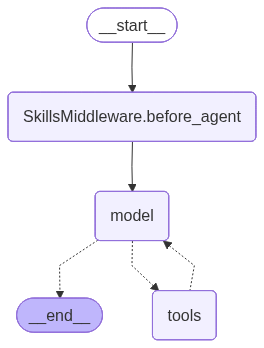

In [90]:
# === Визуализация графа ===
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [94]:
# === Тестовый запуск ===
from utils import format_messages

result = agent.invoke({
    "messages": [{
        "role": "user",
        "content": "Создай навык 'code-reviewer'. Он должен проверять код на Python на соответствие PEP8, искать уязвимости безопасности и предлагать оптимизацию по времени выполнения. Инструкцию сохрани в `/skills/base/code-reviewer/SKILL.md`"
    }]
})

format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Создай навык 'code-reviewer'. Он должен проверять код на Python на соответствие PEP8, искать уязвимости         │
│ безопасности и предлагать оптимизацию по времени выполнения. Инструкцию сохрани в                               │
│ `/skills/base/code-reviewer/SKILL.md`                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Create directory for code-reviewer skill",                                                    │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Write SKILL.md for code-reviewer skill",                                                      │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "status": "pending",                                                                                      │
│       "content": "Verify skill creation"                                                                        │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: tool_write_todos_FJCEUxVj3jwMa19naAyE                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Create directory for code-reviewer skill', 'status': 'pending'}, {'content': │
│ 'Write SKILL.md for code-reviewer skill', 'status': 'pending'}, {'content': 'Verify skill creation', 'status':  │
│ 'pending'}]                                                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Create directory for code-reviewer skill",                                                    │
│       "status": "in_progress"                                                                                   │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Write SKILL.md for code-reviewer skill",                                                      │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "status": "pending",                                                                                      │
│       "content": "Verify skill creation"                                                                        │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: tool_write_todos_V10S3ohuoUZm7FtzdmAC                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Create directory for code-reviewer skill', 'status': 'in_progress'},         │
│ {'content': 'Write SKILL.md for code-reviewer skill', 'status': 'pending'}, {'content': 'Verify skill           │
│ creation', 'status': 'pending'}]                                                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_file                                                                                        │
│    Args: {                                                                                                      │
│   "content": "# Skill: Code Reviewer (Python)\n\nThis skill provides a structured workflow for reviewing Python │
│ code, focusing on PEP 8 compliance, security vulnerabilities, and performance optimization.\n\n##               │
│ Capabilities\n- **PEP 8 Compliance**: Checking code style, naming conventions, and formatting.\n- **Security    │
│ Audit**: Identifying common vulnerabilities (e.g., SQL injection, insecure deserialization, hardcoded           │
│ secrets).\n- **Performance Optimization**: Suggesting algorithmic improvements, efficient data structures, and  │
│ time-complexity reductions.\n\n## Workflow\n\n### 1. Static Analysis & Style (PEP 8)\n- Check indentation (4    │
│ spaces).\n- Verify naming conventions: `snake_case` for functions/variables, `PascalCase` for classes,          │
│ `UPPER_CASE` for constants.\n- Ensure proper spacing around operators and after commas.\n- Check for docstrings │
│ in modules, classes, and functions.\n- Limit line length to 79 characters where possible.\n\n### 2. Security    │
│ Review\n- **Input Validation**: Check if external data is sanitized.\n- **Injection**: Look for `eval()`,       │
│ `exec()`, or raw SQL queries.\n- **Secrets**: Scan for hardcoded API keys, passwords, or tokens.\n- **Standard  │
│ Library**: Check for insecure modules like `pickle`, `telnetlib`, or `random` (for cryptographic                │
│ purposes).\n\n### 3. Performance Optimization\n- **Complexity**: Identify nested loops or O(n^2) operations     │
│ that can be O(n) or O(log n).\n- **Built-ins**: Suggest using built-in functions (e.g., `map`, `filter`, `sum`) │
│ or list comprehensions.\n- **Data Structures**: Recommend `set` for membership checks or `deque` for fast       │
│ appends/pops.\n- **Caching**: Suggest `functools.lru_cache` for repetitive expensive computations.\n\n## Review │
│ Template\n\nWhen performing a review, use the following structure:\n\n### 📝 Style & PEP 8\n- [ ] Issue 1...\n- │
│ [ ] Issue 2...\n\n### 🔒 Security\n- [ ] Vulnerability 1...\n- [ ] Vulnerability 2...\n\n### ⚡ Performance\n-  │
│ [ ] Optimization 1...\n- [ ] Optimization 2...\n\n### 💡 Summary & Refactored Code\nProvide a consolidated      │
│ version of the code incorporating the suggestions.\n\n## Best Practices\n- Be constructive and explain *why* a  │
│ change is recommended.\n- Prioritize security fixes over stylistic preferences.\n- Consider the context: don't  │
│ over-engineer simple scripts.\n",                                                                               │
│   "file_path": "/skills/base/code-reviewer/SKILL.md"                                                            │
│ }                                                                                                               │
│    ID: tool_write_file_iuhIPIXorkjtVWtoqy8O                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated file /skills/base/code-reviewer/SKILL.md                                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "status": "completed",                                                                                    │
│       "content": "Create directory for code-reviewer skill"                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "status": "completed",                                                                                    │
│       "content": "Write SKILL.md for code-reviewer skill"                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Verify skill creation",                                                                       │
│       "status": "in_progress"                                                                                   │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: tool_write_todos_LpgDR0kq254F58ucXgJu                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Create directory for code-reviewer skill', 'status': 'completed'},           │
│ {'content': 'Write SKILL.md for code-reviewer skill', 'status': 'completed'}, {'content': 'Verify skill         │
│ creation', 'status': 'in_progress'}]                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: ls                                                                                                │
│    Args: {}                                                                                                     │
│    ID: tool_ls_tPOrIffsIhmlE9m44jmY                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ ["/skills/base/code-reviewer/SKILL.md"]                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "status": "completed",                                                                                    │
│       "content": "Create directory for code-reviewer skill"                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "status": "completed",                                                                                    │
│       "content": "Write SKILL.md for code-reviewer skill"                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "status": "completed",                                                                                    │
│       "content": "Verify skill creation"                                                                        │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: tool_write_todos_SXDoLd3wVKFA86gwPrCo                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Create directory for code-reviewer skill', 'status': 'completed'},           │
│ {'content': 'Write SKILL.md for code-reviewer skill', 'status': 'completed'}, {'content': 'Verify skill         │
│ creation', 'status': 'completed'}]                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Навык `code-reviewer` успешно создан. Инструкция сохранена в файле `/skills/base/code-reviewer/SKILL.md`.       │
│                                                                                                                 │
│ ### Основные возможности навыка:                                                                                │
│ 1.  **Проверка PEP 8**: Анализ именования, отступов, длины строк и структуры кода.                              │
│ 2.  **Аудит безопасности**: Поиск уязвимостей, таких как использование `eval()`, небезопасная десериализация    │
│ (`pickle`), жестко закодированные секреты и отсутствие валидации входных данных.                                │
│ 3.  **Оптимизация производительности**: Рекомендации по снижению временной сложности алгоритмов, использованию  │
│ эффективных структур данных и встроенных функций Python.                                                        │
│                                                                                                                 │
│ Теперь вы можете использовать этот навык, когда вам потребуется глубокий анализ Python-кода. Просто попросите   │
│ меня применить `code-reviewer` к вашему файлу или фрагменту кода.                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [95]:
skill_path = "/skills/base/code-reviewer/SKILL.md"
if skill_path in result.get("files", {}):
    print("✅ Файл создан в виртуальной ФС:")
    print(result["files"][skill_path])
else:
    print("❌ Файл не найден")

✅ Файл создан в виртуальной ФС:
# Skill: Code Reviewer (Python)

This skill provides a structured workflow for reviewing Python code, focusing on PEP 8 compliance, security vulnerabilities, and performance optimization.

## Capabilities
- **PEP 8 Compliance**: Checking code style, naming conventions, and formatting.
- **Security Audit**: Identifying common vulnerabilities (e.g., SQL injection, insecure deserialization, hardcoded secrets).
- **Performance Optimization**: Suggesting algorithmic improvements, efficient data structures, and time-complexity reductions.

## Workflow

### 1. Static Analysis & Style (PEP 8)
- Check indentation (4 spaces).
- Verify naming conventions: `snake_case` for functions/variables, `PascalCase` for classes, `UPPER_CASE` for constants.
- Ensure proper spacing around operators and after commas.
- Check for docstrings in modules, classes, and functions.
- Limit line length to 79 characters where possible.

### 2. Security Review
- **Input Validation**: Chec

In [96]:
# Продолжаем диалог (важно!)
test_code = '''
def bad_function(x):
    eval("x + 1")  # уязвимость!
    if x > 10:
        return x * x
    else:
        return x + x
'''

test_result = agent.invoke({
    "messages": result["messages"] + [{  # продолжаем предыдущий диалог
        "role": "user",
        "content": f"Примени навык code-reviewer к этому коду:\n\n{test_code}"
    }]
})

from utils import format_messages
format_messages(test_result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Создай навык 'code-reviewer'. Он должен проверять код на Python на соответствие PEP8, искать уязвимости         │
│ безопасности и предлагать оптимизацию по времени выполнения. Инструкцию сохрани в                               │
│ `/skills/base/code-reviewer/SKILL.md`                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Create directory for code-reviewer skill",                                                    │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Write SKILL.md for code-reviewer skill",                                                      │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "status": "pending",                                                                                      │
│       "content": "Verify skill creation"                                                                        │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: tool_write_todos_FJCEUxVj3jwMa19naAyE                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Create directory for code-reviewer skill', 'status': 'pending'}, {'content': │
│ 'Write SKILL.md for code-reviewer skill', 'status': 'pending'}, {'content': 'Verify skill creation', 'status':  │
│ 'pending'}]                                                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Create directory for code-reviewer skill",                                                    │
│       "status": "in_progress"                                                                                   │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Write SKILL.md for code-reviewer skill",                                                      │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "status": "pending",                                                                                      │
│       "content": "Verify skill creation"                                                                        │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: tool_write_todos_V10S3ohuoUZm7FtzdmAC                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Create directory for code-reviewer skill', 'status': 'in_progress'},         │
│ {'content': 'Write SKILL.md for code-reviewer skill', 'status': 'pending'}, {'content': 'Verify skill           │
│ creation', 'status': 'pending'}]                                                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_file                                                                                        │
│    Args: {                                                                                                      │
│   "content": "# Skill: Code Reviewer (Python)\n\nThis skill provides a structured workflow for reviewing Python │
│ code, focusing on PEP 8 compliance, security vulnerabilities, and performance optimization.\n\n##               │
│ Capabilities\n- **PEP 8 Compliance**: Checking code style, naming conventions, and formatting.\n- **Security    │
│ Audit**: Identifying common vulnerabilities (e.g., SQL injection, insecure deserialization, hardcoded           │
│ secrets).\n- **Performance Optimization**: Suggesting algorithmic improvements, efficient data structures, and  │
│ time-complexity reductions.\n\n## Workflow\n\n### 1. Static Analysis & Style (PEP 8)\n- Check indentation (4    │
│ spaces).\n- Verify naming conventions: `snake_case` for functions/variables, `PascalCase` for classes,          │
│ `UPPER_CASE` for constants.\n- Ensure proper spacing around operators and after commas.\n- Check for docstrings │
│ in modules, classes, and functions.\n- Limit line length to 79 characters where possible.\n\n### 2. Security    │
│ Review\n- **Input Validation**: Check if external data is sanitized.\n- **Injection**: Look for `eval()`,       │
│ `exec()`, or raw SQL queries.\n- **Secrets**: Scan for hardcoded API keys, passwords, or tokens.\n- **Standard  │
│ Library**: Check for insecure modules like `pickle`, `telnetlib`, or `random` (for cryptographic                │
│ purposes).\n\n### 3. Performance Optimization\n- **Complexity**: Identify nested loops or O(n^2) operations     │
│ that can be O(n) or O(log n).\n- **Built-ins**: Suggest using built-in functions (e.g., `map`, `filter`, `sum`) │
│ or list comprehensions.\n- **Data Structures**: Recommend `set` for membership checks or `deque` for fast       │
│ appends/pops.\n- **Caching**: Suggest `functools.lru_cache` for repetitive expensive computations.\n\n## Review │
│ Template\n\nWhen performing a review, use the following structure:\n\n### 📝 Style & PEP 8\n- [ ] Issue 1...\n- │
│ [ ] Issue 2...\n\n### 🔒 Security\n- [ ] Vulnerability 1...\n- [ ] Vulnerability 2...\n\n### ⚡ Performance\n-  │
│ [ ] Optimization 1...\n- [ ] Optimization 2...\n\n### 💡 Summary & Refactored Code\nProvide a consolidated      │
│ version of the code incorporating the suggestions.\n\n## Best Practices\n- Be constructive and explain *why* a  │
│ change is recommended.\n- Prioritize security fixes over stylistic preferences.\n- Consider the context: don't  │
│ over-engineer simple scripts.\n",                                                                               │
│   "file_path": "/skills/base/code-reviewer/SKILL.md"                                                            │
│ }                                                                                                               │
│    ID: tool_write_file_iuhIPIXorkjtVWtoqy8O                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated file /skills/base/code-reviewer/SKILL.md                                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "status": "completed",                                                                                    │
│       "content": "Create directory for code-reviewer skill"                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "status": "completed",                                                                                    │
│       "content": "Write SKILL.md for code-reviewer skill"                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Verify skill creation",                                                                       │
│       "status": "in_progress"                                                                                   │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: tool_write_todos_LpgDR0kq254F58ucXgJu                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Create directory for code-reviewer skill', 'status': 'completed'},           │
│ {'content': 'Write SKILL.md for code-reviewer skill', 'status': 'completed'}, {'content': 'Verify skill         │
│ creation', 'status': 'in_progress'}]                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: ls                                                                                                │
│    Args: {}                                                                                                     │
│    ID: tool_ls_tPOrIffsIhmlE9m44jmY                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ ["/skills/base/code-reviewer/SKILL.md"]                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "status": "completed",                                                                                    │
│       "content": "Create directory for code-reviewer skill"                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "status": "completed",                                                                                    │
│       "content": "Write SKILL.md for code-reviewer skill"                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "status": "completed",                                                                                    │
│       "content": "Verify skill creation"                                                                        │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: tool_write_todos_SXDoLd3wVKFA86gwPrCo                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Create directory for code-reviewer skill', 'status': 'completed'},           │
│ {'content': 'Write SKILL.md for code-reviewer skill', 'status': 'completed'}, {'content': 'Verify skill         │
│ creation', 'status': 'completed'}]                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Навык `code-reviewer` успешно создан. Инструкция сохранена в файле `/skills/base/code-reviewer/SKILL.md`.       │
│                                                                                                                 │
│ ### Основные возможности навыка:                                                                                │
│ 1.  **Проверка PEP 8**: Анализ именования, отступов, длины строк и структуры кода.                              │
│ 2.  **Аудит безопасности**: Поиск уязвимостей, таких как использование `eval()`, небезопасная десериализация    │
│ (`pickle`), жестко закодированные секреты и отсутствие валидации входных данных.                                │
│ 3.  **Оптимизация производительности**: Рекомендации по снижению временной сложности алгоритмов, использованию  │
│ эффективных структур данных и встроенных функций Python.                                                        │
│                                                                                                                 │
│ Теперь вы можете использовать этот навык, когда вам потребуется глубокий анализ Python-кода. Просто попросите   │
│ меня применить `code-reviewer` к вашему файлу или фрагменту кода.                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Примени навык code-reviewer к этому коду:                                                                       │
│                                                                                                                 │
│                                                                                                                 │
│ def bad_function(x):                                                                                            │
│     eval("x + 1")  # уязвимость!                                                                                │
│     if x > 10:                                                                                                  │
│         return x * x                                                                                            │
│     else:                                                                                                       │
│         return x + x                                                                                            │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: read_file                                                                                         │
│    Args: {                                                                                                      │
│   "file_path": "/skills/base/code-reviewer/SKILL.md"                                                            │
│ }                                                                                                               │
│    ID: tool_read_file_PfpAQ0kCAg3gzMmJu2Uu                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Error: File '/skills/base/code-reviewer/SKILL.md' not found                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: ls                                                                                                │
│    Args: {}                                                                                                     │
│    ID: tool_ls_ed5eHO4ykJjOCvftdkvc                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_file                                                                                        │
│    Args: {                                                                                                      │
│   "content": "# Skill: Code Reviewer (Python)\n\nThis skill provides a structured workflow for reviewing Python │
│ code, focusing on PEP 8 compliance, security vulnerabilities, and performance optimization.\n\n##               │
│ Capabilities\n- **PEP 8 Compliance**: Checking code style, naming conventions, and formatting.\n- **Security    │
│ Audit**: Identifying common vulnerabilities (e.g., SQL injection, insecure deserialization, hardcoded           │
│ secrets).\n- **Performance Optimization**: Suggesting algorithmic improvements, efficient data structures, and  │
│ time-complexity reductions.\n\n## Workflow\n\n### 1. Static Analysis & Style (PEP 8)\n- Check indentation (4    │
│ spaces).\n- Verify naming conventions: `snake_case` for functions/variables, `PascalCase` for classes,          │
│ `UPPER_CASE` for constants.\n- Ensure proper spacing around operators and after commas.\n- Check for docstrings │
│ in modules, classes, and functions.\n- Limit line length to 79 characters where possible.\n\n### 2. Security    │
│ Review\n- **Input Validation**: Check if external data is sanitized.\n- **Injection**: Look for `eval()`,       │
│ `exec()`, or raw SQL queries.\n- **Secrets**: Scan for hardcoded API keys, passwords, or tokens.\n- **Standard  │
│ Library**: Check for insecure modules like `pickle`, `telnetlib`, or `random` (for cryptographic                │
│ purposes).\n\n### 3. Performance Optimization\n- **Complexity**: Identify nested loops or O(n^2) operations     │
│ that can be O(n) or O(log n).\n- **Built-ins**: Suggest using built-in functions (e.g., `map`, `filter`, `sum`) │
│ or list comprehensions.\n- **Data Structures**: Recommend `set` for membership checks or `deque` for fast       │
│ appends/pops.\n- **Caching**: Suggest `functools.lru_cache` for repetitive expensive computations.\n\n## Review │
│ Template\n\nWhen performing a review, use the following structure:\n\n### 📝 Style & PEP 8\n- [ ] Issue         │
│ 1...\n\n### 🔒 Security\n- [ ] Vulnerability 1...\n\n### ⚡ Performance\n- [ ] Optimization 1...\n\n### 💡      │
│ Summary & Refactored Code\nProvide a consolidated version of the code incorporating the suggestions.\n",        │
│   "file_path": "/skills/base/code-reviewer/SKILL.md"                                                            │
│ }                                                                                                               │
│    ID: tool_write_file_XIm9tNgHctDYhMx2XVVm                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated file /skills/base/code-reviewer/SKILL.md                                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Применяю навык **code-reviewer** к предоставленному коду.                                                       │
│                                                                                                                 │
│ ### 📝 Style & PEP 8                                                                                            │
│ - [ ] **Отсутствие Docstring**: Функция не имеет строки документации, описывающей её назначение, аргументы и    │
│ возвращаемое значение.                                                                                          │
│ - [ ] **Лишние вычисления**: Вызов `eval("x + 1")` не сохраняет результат и не влияет на логику, являясь        │
│ "мертвым кодом".                                                                                                │
│                                                                                                                 │
│ ### 🔒 Security                                                                                                 │
│ - [ ] **Критическая уязвимость (Injection)**: Использование функции `eval()` крайне опасно, так как она         │
│ исполняет произвольный код. В данном контексте она абсолютно избыточна. Если необходимо динамическое вычисление │
│ выражений, следует использовать `ast.literal_eval()` (для данных) или специализированные библиотеки с           │
│ парсингом, но здесь достаточно обычных арифметических операторов.                                               │
│                                                                                                                 │
│ ### ⚡ Performance                                                                                              │
│ - [ ] **Лишняя операция**: Интерпретация строки через `eval` — это очень медленная операция по сравнению с      │
│ нативным кодом Python. Её удаление значительно ускорит выполнение функции.                                      │
│                                                                                                                 │
│ ### 💡 Summary & Refactored Code                                                                                │
│ Код содержит опасную уязвимость и неэффективное использование ресурсов. Рекомендуется удалить `eval` и добавить │
│ документацию.                                                                                                   │
│                                                                                                                 │
│ ```python                                                                                                       │
│ def calculate_value(x: int) -> int:                                                                             │
│     """                                                                                                         │
│     Вычисляет квадрат числа, если оно больше 10, иначе удваивает его.                                           │
│                                                                                                                 │
│     Args:                                                                                                       │
│         x: Входное целое число.                                                                                 │
│                                                                                                                 │
│     Returns:                                                                                                    │
│         Результат вычисления.                                                                                   │
│     """                                                                                                         │
│     if x > 10:                                             